In [29]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt

# Last Video

A general "sequential" neural network can be expressed as

$$f(x) = \underset{i=1}{\overset{n}{\Huge{\kappa}}} R_i(A_ix+b_i)$$

where $$\underset{i=1}{\overset{n}{\Huge{\kappa}}}f_i(x) = f_n \circ f_{n-1} ... \circ f_1(x)$$ and the $A_i$ are matrices and the $b_i$ are bias vectors. Typically the $R_i$ are the same for all the layers (typically ReLU) **except** for the last layer, where $R_i$ is just is just the identity function

* **Note**: In clever architectures, like convolutional neural networks, the $A_i$'s become sparse matrices (most of there parameters are fixed to equal zero).

# This Video

Datasets and proper training

Download from www.di.ens.fr/~lelarge/MNIST.tar.gz

In [60]:
x, y = torch.load('C:\\files\\MNIST\\MNIST\\processed\\training.pt')

In [61]:
x.shape

torch.Size([60000, 28, 28])

In [62]:
y.shape

torch.Size([60000])

In [63]:
y.dtype

torch.int64

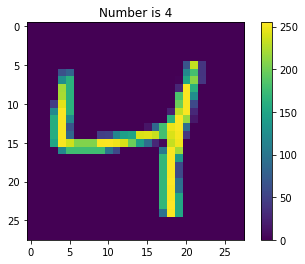

In [64]:
plt.imshow(x[2].numpy())
plt.title(f'Number is {y[2].numpy()}')
plt.colorbar()
plt.show()

# The One Hot Encoder

In [35]:
x = torch.tensor([2, 4, 3, 0, 1])
y = F.one_hot(x, num_classes=6)

In [36]:
x

tensor([2, 4, 3, 0, 1])

In [37]:
y

tensor([[0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]])

In [38]:
x.shape

torch.Size([5])

In [39]:
y.shape

torch.Size([5, 6])

# PyTorch Dataset Object

In [65]:
class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10)
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, ix): 
        return self.x[ix], self.y[ix]

In [66]:
ds = CTDataset('C:\\files\\MNIST\\MNIST\\processed\\training.pt')

In [71]:
xs, ys = ds[0:4]

In [72]:
xs.shape

torch.Size([4, 28, 28])

In [73]:
ys.shape

torch.Size([4, 10])

# Cross Entropy Loss

Entropy is a measure of chaos. Suppose we know that the distribution of some variable $y$ is $p(y)$ but we take data and estimate this distribution as $q(y)$. In our case, $y$ can take on 10 different digit values, so its a discrete distribution. The cross entropy is defined as

$$H(p,q) = -\sum_{\forall y} p(y)\ln(q(y))$$

In the continuous case, this is an integral with pdfs: $H(p,q) = -\int_y p(y)\ln(q(y)) dy$ **What's most important is that this function is minimized when $p$ and $q$ are the same function**.

## For a Single Image

In our case, **for a single image**:

$$H(p,q) = -\sum_{i=0}^{9} p(i)\ln(q(i))$$

where $p(i)$ is the **true** proability that this image represents digit $i$, and $q(i)$ is our estimated probability. Note that we will need to output $10$ estimated probabilities (the $q(i)$'s) for each image (so our network output is a vector of size 10).

Now in our case we know the ground truth. Suppose we know the image is the digit $j$. Then $p(j)=1$ and all the other probabilities are $0$, so:

$$H(p,q) =  - \ln(q(j)) $$

## For Multiple Images

In this case, consider us computing this loss over $N$ images. We sum it together:

$$L(p,q) \equiv \sum_{n=0}^N H(p^{(n)}, q^{(n)}) = - \sum_{n=0}^N \ln(q(j_n))$$

where $j_n$ is the digit label of the $n$th image in the batch.

## How Do We Get The $q$'s?

$q(j_n)$ should be *related* to a probability density function
* Bounded between 0 and 1
* The closer to 0, the less likely we are confident that image $n$ is image $j$
* The closer to 1, the more likely we are confident that image $n$ is image $j$

Since our neural network outputs 10 values (10 arbitrary numbers) we can normalize these numbers to be a probability density function as follows:

$$q(j_n) = \frac{\exp{\left(\hat{y}_n(j_n)\right)}}{\sum_{j=0}^9 \exp{\left(\hat{y}_n(j_n)\right)}}$$

So we can write our loss as

$$L(\hat{y}) = - \sum_{n=0}^N \frac{\exp{\left(\hat{y}_n(j_n)\right)}}{\sum_{j=0}^9 \exp{\left(\hat{y}_n(j_n)\right)}}$$

* $\hat{y}_n$ is the network output for image $n$. It is a vector of length 10 (network outputs 10 numbers per image).
* $j_n$ is the digit label of the $n$th image
* $\hat{y}_n(j_n)$ is a single number from the vector $\hat{y}_n$ that is proportional to the "confidence" of the network that image $n$ is the digit $j_n$.

# Coding This Up

# Training